# Réalisez une analyse de sentiments grâce au Deep Learning



 Vous êtes ingénieur IA chez MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital.

Dans deux semaines, vous avez rendez-vous avec Mme Aline, directrice marketing de la compagnie aérienne “Air Paradis”.

## Analyse du jeu de données : Prédire le sentiment associé à un tweet

### Récupération du jeu de données sur kaggle

- [Lien téléchargement du jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip)
- [Lien Kaggle du jeu de données _Sentiment140 dataset with 1.6 million tweets_](https://www.kaggle.com/datasets/kazanova/sentiment140)
- context du dataset : 
    - This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

#### Importation des librairies

In [1]:
import os
import pandas as pd
import requests
import zipfile
import matplotlib.pyplot as plt
import chardet
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

#### Script récupération du jeu de données

In [2]:
# URL file to download
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
# Folder to stock files
dataset_folder = "dataset"
zip_file_path = "sentiment140.zip"
csv_file_name = "training.1600000.processed.noemoticon.csv"

# Create folder 'dataset' if don't exist
os.makedirs(dataset_folder, exist_ok=True)

# Verify if CSV file exist
csv_path = os.path.join(dataset_folder, csv_file_name)
if os.path.exists(csv_path):
    print(f"Le fichier CSV existe déjà : {csv_path}")
else:
    # Download zip file if don't exist
    if not os.path.exists(zip_file_path):
        print("Téléchargement du fichier ZIP...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(zip_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            print(f"Fichier ZIP téléchargé : {zip_file_path}")
        else:
            print("Erreur lors du téléchargement du fichier ZIP")
            exit(1)
    else:
        print(f"Le fichier ZIP existe déjà : {zip_file_path}")

    # Extraction ZIP file
    print("Extraction du fichier ZIP...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Extraction terminée.")

    # Verify if csv exist after extraction
    if os.path.exists(csv_path):
        print(f"Le fichier CSV a été extrait avec succès : {csv_path}")
    else:
        print("Le fichier CSV n'a pas été trouvé après extraction.")

print("Processus terminé.")

Le fichier CSV existe déjà : dataset/training.1600000.processed.noemoticon.csv
Processus terminé.


#### Import du jeu de données


##### Vérification de l'encodage des données

In [3]:
with open("dataset/training.1600000.processed.noemoticon.csv", "rb") as f:
    result = chardet.detect(f.read(10000))
print(result["encoding"])

ascii


##### Import des données 

In [32]:
columns = ["target", "ids", "date", "flag", "user", "text"]
df_sentiment = pd.read_csv(
    "dataset/training.1600000.processed.noemoticon.csv",
    encoding="utf-8",
    encoding_errors="ignore",  # ignore caractere no decodable
    names=columns,
)
# Map target labels: 0 -> Negative, 4 -> Positive
df_sentiment["target"] = df_sentiment["target"].map({0: 0, 4: 1})
# Create a columns for sentiment
df_sentiment["sentiment"] = [
    "Negative" if x == 0 else "Positive" for x in df_sentiment["target"]
]
df_sentiment.head()

,target,ids,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative


In [4]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
 6   sentiment  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


- Information sur sur les colonnes : 
 1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

 2. ids: The id of the tweet (2087)

 3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

 4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.

 5. user: the user that tweeted (robotickilldozr)



### Analyse exploratoire du jeu de données

#### Distribution des sentiments des tweets 

/tmp/ipykernel_202662/873848287.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


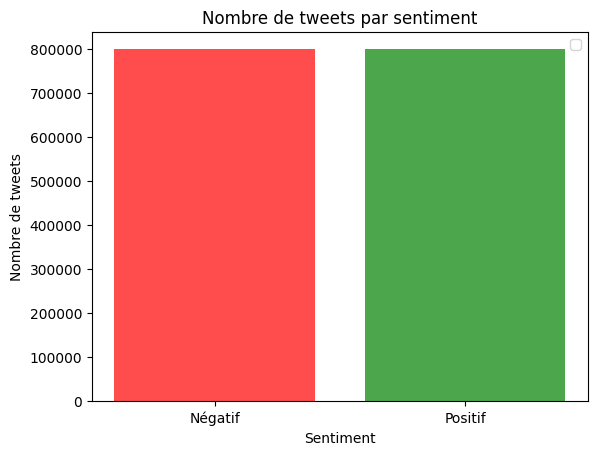

In [5]:
# check the number of different sentiment values on dataframe

negatif_count = df_sentiment[df_sentiment["target"] == 0].shape[0]
positif_count = df_sentiment[df_sentiment["target"] == 1].shape[0]

categories = ["Négatif", "Positif"]
counts = [negatif_count, positif_count]
colors = ["red", "green"]

plt.bar(categories, counts, color=colors, alpha=0.7)
plt.title("Nombre de tweets par sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de tweets")
plt.legend()
plt.show()

#### Distribution mots des tweets

In [6]:
print(len(df_sentiment["text"]))

1600000


In [7]:
number_of_tweet = len(df_sentiment["text"])
df_sentiment_lens = df_sentiment["text"].str.len()

total_word_df_sentiment, df_sentiment_min, df_sentiment_max = (
    df_sentiment_lens.sum(),
    df_sentiment_lens.min(),
    df_sentiment_lens.max(),
)


print(
    f" {'-' * 40} \n Nombre de tweets: {number_of_tweet}\n Nombre de mot dans total dans les tweets : {total_word_df_sentiment}\n Nombre de mot mininum pour un tweet : {df_sentiment_min}\n Nombre de mot maximum pour un tweet : {df_sentiment_max}\n{'-' * 40} \n"
)

 ---------------------------------------- 
 Nombre de tweets: 1600000
 Nombre de mot dans total dans les tweets : 118461232
 Nombre de mot mininum pour un tweet : 6
 Nombre de mot maximum pour un tweet : 235
---------------------------------------- 



#### Wordcloud des sentiments des tweets

##### Nettoyage du texte

In [33]:
# Télécharger les stopwords français
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


# Fonction for clean text
def clean_text(text):
    # Convert to lower
    text = text.lower()
    # delete special caracter
    text = re.sub(r"\W", " ", text)
    # Remove mentions
    text = re.sub(r"@\w+", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d", " ", text)
    # Remove empty word
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Join clean words
    text = " ".join(words)
    return text


# Apply clean text to columns
df_sentiment["text_clean"] = df_sentiment["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dimitri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df_sentiment.head()

,target,ids,date,flag,user,text,sentiment,text_clean
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative,switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Negative,kenichan dived many times ball managed save re...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative,nationwideclass behaving mad see


In [35]:
empty_text = df_sentiment[
    df_sentiment["text_clean"].isnull() | (df_sentiment["text_clean"] == "")
]
print(f"Lignes problématiques :\n{empty_text}")

Lignes problématiques :
         target         ids                          date      flag  \
3997          0  1468720797  Tue Apr 07 03:21:48 PDT 2009  NO_QUERY   
4233          0  1468771833  Tue Apr 07 03:39:06 PDT 2009  NO_QUERY   
18950         0  1556733475  Sun Apr 19 00:05:23 PDT 2009  NO_QUERY   
19062         0  1556760319  Sun Apr 19 00:12:56 PDT 2009  NO_QUERY   
24317         0  1557961366  Sun Apr 19 06:44:36 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1592715       1  2191790700  Tue Jun 16 05:58:39 PDT 2009  NO_QUERY   
1595775       1  2192466848  Tue Jun 16 07:04:51 PDT 2009  NO_QUERY   
1596318       1  2192628378  Tue Jun 16 07:19:07 PDT 2009  NO_QUERY   
1598921       1  2193305981  Tue Jun 16 08:16:39 PDT 2009  NO_QUERY   
1599811       1  2193550913  Tue Jun 16 08:36:39 PDT 2009  NO_QUERY   

                   user                 text sentiment text_clean  
3997         mohdnajwan          what to do   Negative 

In [36]:
# Delete empty rows after cleaning
df_sentiment = df_sentiment[df_sentiment["text_clean"] != ""]

In [ ]:
# Separate texts by sentiment
positive_text = " ".join(df_sentiment[df_sentiment["target"] == 1]["text_clean"])
negative_text = " ".join(df_sentiment[df_sentiment["target"] == 0]["text_clean"])

# Generate word cloud for positive texts
wordcloud_positive = WordCloud(
    width=800, height=400, background_color="white"
).generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiments")
plt.show()

# Generate word cloud for negative texts
wordcloud_negative = WordCloud(
    width=800, height=400, background_color="white"
).generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiments")
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ae1a2446270>>
Traceback (most recent call last):
  File "/home/dimitri/anaconda3/envs/projet_7/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


#### Export des données 

In [37]:
df_sentiment.to_csv(
    "dataset/dataset_sentiment_clean.csv", index=False, encoding="utf-8"
)